

<figure>
   <IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">
</figure>
    
# Local grid refinement   

This notebook shows an example of an unstructured model create with the `nlmod` package.

### Table of contents
1. [Create model](#create)
2. [Run model](#run)
3. [Visualise](#Visualise)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd

import nlmod

print(f'nlmod version: {nlmod.__version__}')

nlmod version: 0.0.1b


### 1. Create model<a name="create"></a>

Modflow 6 makes it possible to use locally refined grids. In NLmod you can use a shapefile and a number of levels to specify where and how much you want to use local grid refinement. Below we use a shapefile of the Planetenweg in IJmuiden and set the refinement levels at 2. This well create a grid with cells of 100x100m except at the Planetenweg where the cells will be refined to 25x25m. See also figures below.

Note: the `gen_model_unstructured` function also returns the `gridprops` dictionary. This contains data that is necesary to create some packages. It can be time consuming to generate this data.

In [2]:
# model settings unstructured
model_ws = 'model2'
model_name = 'IJm_planeten'
refine_shp_fname = os.path.join(nlmod.nlmod_datadir, 'shapes', 'planetenweg_ijmuiden')
levels=2
use_cache=False
extent=[95000., 105000., 494000., 500000.]
delr=100.
delc=100.
steady_state=False
steady_start=True
transient_timesteps=5
perlen=1.
verbose=True
start_time='2015-1-1'
gridtype = 'unstructured'
use_regis=True
regis_botm_layer=b'MSz1'
use_geotop=True
add_northsea=True
starting_head=1.0

In [3]:
# Model directories
figdir, cachedir, gridgen_ws = nlmod.util.get_model_dirs(model_ws, gridtype=gridtype)


# create model time dataset
model_ds = nlmod.mtime.get_model_ds_time(model_name, model_ws, start_time,
                                         steady_state, steady_start=steady_start,
                                         transient_timesteps=transient_timesteps,
                                         perlen=perlen)

# create modflow packages
sim, gwf = nlmod.mfpackages.sim_tdis_gwf_ims_from_model_ds(model_ds,
                                                           verbose=verbose)

extent, nrow, ncol = nlmod.read.regis.fit_extent_to_regis(extent,
                                                          delr,
                                                          delc, verbose=verbose)

# layer model
layer_model = nlmod.read.regis.get_layer_models(extent, delr, delc,
                                                use_regis=use_regis,
                                                regis_botm_layer=regis_botm_layer,
                                                use_geotop=use_geotop,
                                                cachedir=cachedir,
                                                fname_netcdf='combined_layer_ds.nc',
                                                use_cache=use_cache,
                                                verbose=verbose)


creating modflow SIM, TDIS, GWF and IMS
redefining current extent: [95000.0, 105000.0, 494000.0, 500000.0], fit to regis raster
new extent is [94950.0, 105050.0, 493950.0, 500050.0] model has 61 rows and 101 columns
creating and caching dataset combined_layer_ds.nc



### Local grid refinement

the code below applies a local grid refinement to the layer model. The local grid refinement is based on the shapefile 'planetenweg_ijmuiden.shp', which contains a line shape of the Planetenweg, and the levels, which is 2. This means that the model cells at the Planetenweg will get a size of 25 x 25m. 

In [4]:
# use gridgen to create unstructured grid
gridprops = nlmod.mgrid.create_unstructured_grid(gridgen_ws, model_name, gwf,
                                                 refine_shp_fname, levels, extent,
                                                 layer_model.dims['layer'],
                                                 nrow, ncol,
                                                 delr, delc,
                                                 cachedir=cachedir, use_cache=use_cache,
                                                 verbose=verbose)

# add layer model to unstructured grid
layer_model_unstr = nlmod.mgrid.get_ml_layer_dataset_unstruc(raw_ds=layer_model,
                                                            extent=extent,
                                                            gridprops=gridprops,
                                                            cachedir=cachedir,
                                                            fname_netcdf='layer_model_unstr.nc',
                                                            use_cache=use_cache,
                                                            verbose=verbose)

# combine model time dataset with layer model dataset
model_ds = nlmod.mgrid.update_model_ds_from_ml_layer_ds(model_ds,
                                                          layer_model_unstr,
                                                          gridtype,
                                                          keep_vars=['x', 'y'],
                                                          gridprops=gridprops,
                                                          add_northsea=add_northsea,
                                                          verbose=verbose)

# Create discretization
disv = nlmod.mfpackages.disv_from_model_ds(model_ds, gwf, gridprops)

create unstructured grid using gridgen
write cache for griddata data to model2\cache\gridprops.pklz
creating and caching dataset layer_model_unstr.nc

add kh and kv from model layer dataset to modflow model
layer 0 has a kh
layer 1 has a kh
layer 2 has a kh
layer 3 has a kh
layer 4 has a kh
layer 5 has a kh
layer 6 has a kh
layer 7 has a kh
layer 8 has a kh
layer 9 has a kh
layer 10 has a kh
layer 11 has a kh
layer 12 has a kh
layer 13 has a kh
layer 14 has a kv
layer 15 has a kh
layer 16 has a kv
layer 17 has a kh
layer 18 has a kh
layer 19 has a kv
layer 20 has a kh
layer 21 has a kv
layer 22 has a kh
layer 23 has a kh
layer 24 has a kh
layer 25 has a kh
layer 26 has a kv
layer 27 has a kh
layer 28 has a kh
layer 29 has a kv
layer 30 has a kh
layer 31 has a kh
layer 32 has a kh
layer 33 has a kv
layer 34 has a kh
layer 35 has a kv
layer 36 has a kh
layer 37 has a kh
layer 38 has a kh
layer 39 has a kh
layer 0 has a kv
layer 1 has a kv
layer 2 has a kv
layer 3 has a kv
layer 4 has a k

Downloading...
From: https://drive.google.com/uc?id=1uNy4THL3FmNFrTDTfizDAl0lxOH-yCEo
To: C:\Users\oebbe\02_python\nlmod\examples\model2\jarkus_nhflopy.nc
131MB [00:10, 12.1MB/s] 


In [5]:
# create node property flow
nlmod.mfpackages.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
nlmod.mfpackages.ic_from_model_ds(model_ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.mfpackages.oc_from_model_ds(model_ds, gwf)

In [6]:
# voeg grote oppervlaktewaterlichamen toe
da_name = 'surface_water'
model_ds = nlmod.mfpackages.surface_water.get_general_head_boundary(model_ds,
                                                                    gwf.modelgrid,
                                                                    da_name,
                                                                    cachedir=cachedir,
                                                                    use_cache=use_cache,
                                                                    verbose=verbose)
ghb = nlmod.mfpackages.ghb_from_model_ds(model_ds, gwf, da_name)

# surface level drain
model_ds = nlmod.read.ahn.get_ahn_dataset(model_ds, gridprops=gridprops,
                                          use_cache=use_cache,
                                           cachedir=cachedir, verbose=verbose)

drn = nlmod.mfpackages.surface_drain_from_model_ds(model_ds, gwf)



# add constant head cells at model boundaries
chd = nlmod.mfpackages.chd_at_model_edge_from_model_ds(model_ds, gwf, head='starting_head')

creating and caching dataset ghb_model_ds.nc

creating and caching dataset ahn_model_ds.nc

requested ahn raster width or height bigger than 4000.0
            -> splitting extent into 3 * 2 tiles
downloading subextent [94950.0, 98950.0, 493950.0, 497950.0]
x_segement 0, y_segement0
- from cache C:\Users\oebbe\AppData\Local\Temp\ahn\ahn3_5m_dtm\ahn_94950_98950_493950_497950_5000.tiff
downloading subextent [94950.0, 98950.0, 497950.0, 500050.0]
x_segement 0, y_segement1
- from cache C:\Users\oebbe\AppData\Local\Temp\ahn\ahn3_5m_dtm\ahn_94950_98950_497950_500050_5000.tiff
downloading subextent [98950.0, 102950.0, 493950.0, 497950.0]
x_segement 1, y_segement0
- from cache C:\Users\oebbe\AppData\Local\Temp\ahn\ahn3_5m_dtm\ahn_98950_102950_493950_497950_5000.tiff
downloading subextent [98950.0, 102950.0, 497950.0, 500050.0]
x_segement 1, y_segement1
- from cache C:\Users\oebbe\AppData\Local\Temp\ahn\ahn3_5m_dtm\ahn_98950_102950_497950_500050_5000.tiff
downloading subextent [102950.0, 105050

In [7]:
# do not add recharge due to knmi api problems
# # add knmi recharge to the model datasets
# model_ds = nlmod.read.knmi.get_recharge(model_ds,
#                                   verbose=verbose,
#                                   cachedir=cachedir,
#                                   use_cache=use_cache)
# # create recharge package
# mfpackages.rch_from_model_ds(model_ds, gwf)

In [8]:
# save model_ds
model_ds.to_netcdf(os.path.join(cachedir, 'full_model_ds.nc'))

### 2. Run<a name="run"></a>
The model that we've created has not been runned yet. When you want to save and run the model you can use the code below.

Note: You always have to write the modflow data to the model workspace before you can run the model. 

In [9]:
gwf.simulation.write_simulation()
gwf.simulation.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJm_planeten...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package chd...
FloPy is using the following  executable to run the model: C:\Users\oebbe\04_software\executables\mf6.EXE
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 08:24:05 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 


(True, [])

### 3. Visualise<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

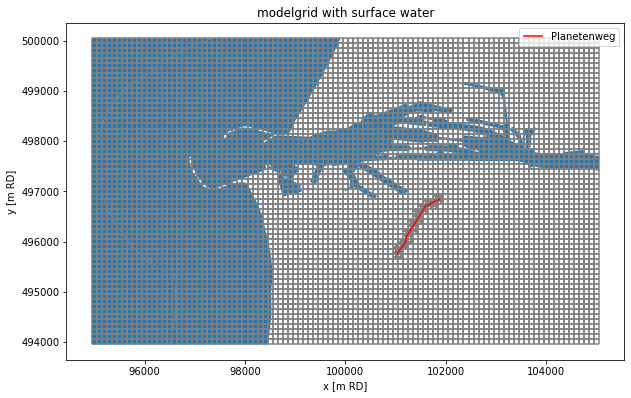

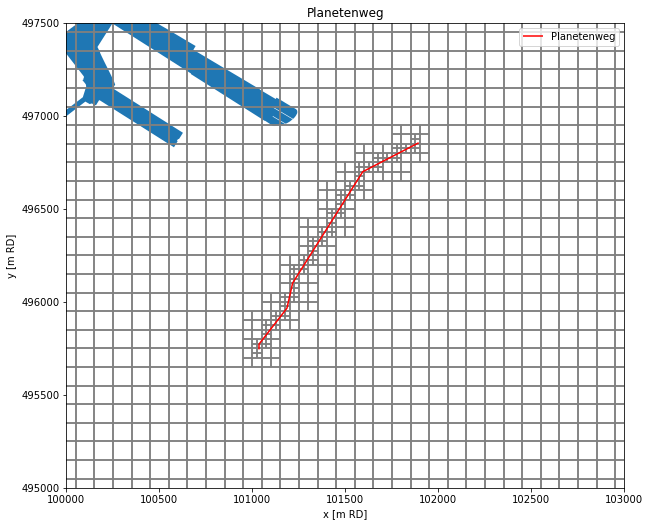

In [10]:
plan_weg_gdf= gpd.read_file(refine_shp_fname+'.shp')

# plot modelgrid
ax = nlmod.plots.plot_modelgrid(model_ds, gwf)
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.legend()
ax.get_figure().savefig(os.path.join(figdir, 'mgrid_swater.png'), bbox_inches='tight')

# plot zoomed modelgrid
ax = nlmod.plots.plot_modelgrid(model_ds, gwf)
ax.set_title('Planetenweg')
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.set_xlim(100000, 103000)
ax.set_ylim(495000,497500)
ax.legend()
ax.get_figure().savefig(os.path.join(figdir, 'Planetenweg.png'), bbox_inches='tight')

The model dataset of an unstructured model differs from a structured model dataset. The data is stored relative to the cell-id instead of the row and column number. Therefore the model dataset has the dimension cid instead of the dimensions x and y. 

In [11]:
model_ds

<xarray.Dataset>
Dimensions:             (cid: 6389, layer: 40, time: 6)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-03 ... 2015-01-05
  * cid                 (cid) int32 0 1 2 3 4 5 ... 6384 6385 6386 6387 6388
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
Data variables:
    time_steps          (time) int32 0 1 2 3 4 5
    x                   (cid) float64 9.5e+04 9.51e+04 ... 1.049e+05 1.05e+05
    y                   (cid) float64 5e+05 5e+05 5e+05 ... 4.94e+05 4.94e+05
    idomain             (layer, cid) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (cid) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    bot                 (layer, cid) float64 -12.02 -11.88 ... -218.5 -218.8
    top                 (cid) float64 0.0 0.0 0.0 0.0 0.0 ... 1.49 0.5 0.37 0.37
    kh                  (layer, cid) float64 10.0 10.0 10.0 ... 6.11 6.11 6.12
    kv                  (layer, cid) float64 10.0 10.0 10.0 ... 0.611 0.612
    area                (cid) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04 1e+04
    northsea            (cid) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    bathymetry          (cid) float64 -12.02 -11.88 -11.88 ... nan nan nan
    thickness           (layer, cid) float64 12.02 11.88 11.88 ... 0.13 0.09999
    starting_head       (layer, cid) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    surface_water_area  (cid) float64 1e+04 1e+04 1e+04 1e+04 ... 0.0 0.0 0.0
    surface_water_cond  (cid) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    surface_water_peil  (cid) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (cid) float64 nan nan nan nan ... 1.134 1.28 0.101 0.328
    chd                 (layer, cid) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    model_name:        IJm_planeten
    model_ws:          model2
    time_units:        DAYS
    start_time:        2005-01-03 00:00:00
    nper:              6
    perlen:            1.0
    nstp:              1
    tsmult:            1.0
    mfversion:         mf6
    steady_start:      1
    steady_state:      0
    gridtype:          unstructured
    delr:              100.0
    delc:              100.0
    levels:            2
    extent:            [94950.0, 105050.0, 493950.0, 500050.0]
    nodata:            -999
    anisotropy:        10
    fill_value_kh:     1.0
    fill_value_kv:     0.1
    surface_drn_cond:  1000

To plot the same rasters as for the previous model we can use the `nlmod.plots.plot_array()` function.

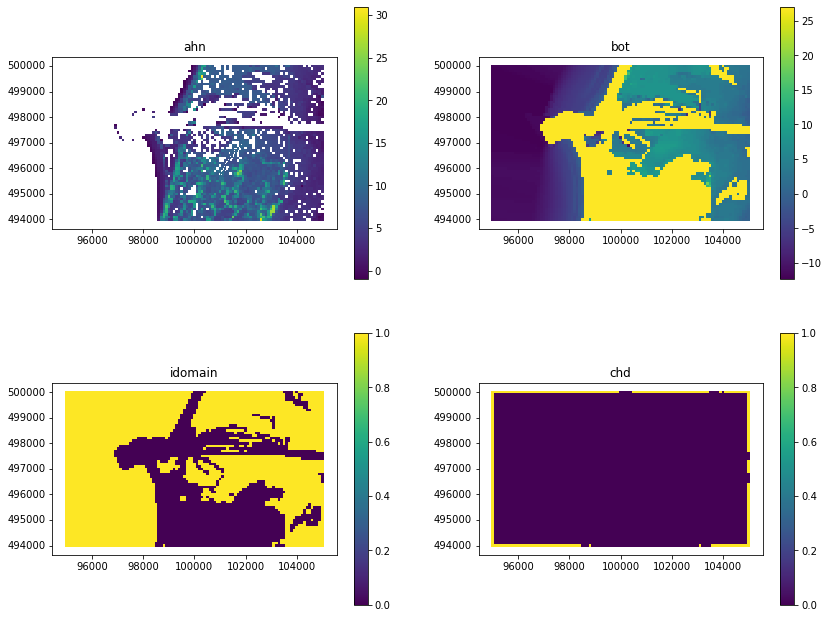

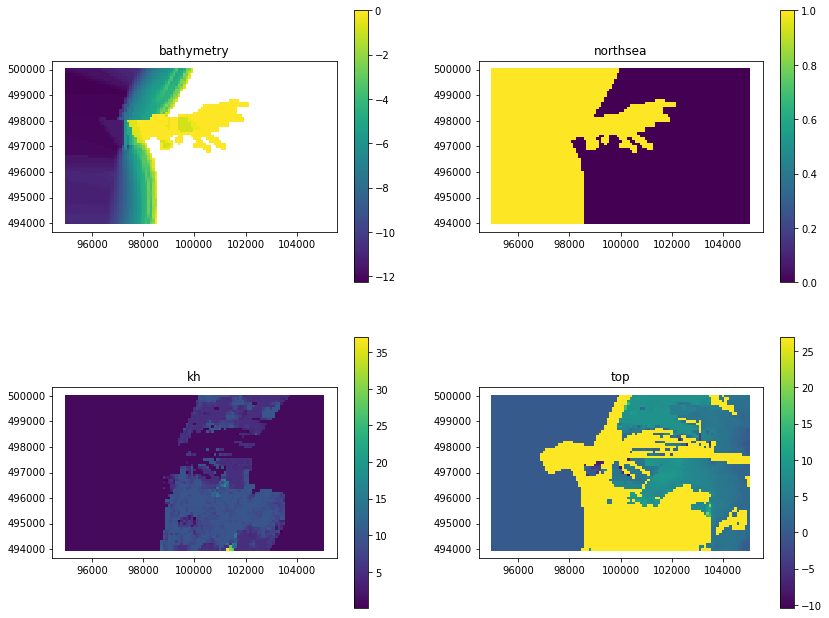

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,11))
nlmod.plots.plot_array(gwf, model_ds['ahn'], ax=axes[0][0])
nlmod.plots.plot_array(gwf, model_ds['bot'][0],ax=axes[0][1])
nlmod.plots.plot_array(gwf, model_ds['idomain'][0],ax=axes[1][0])
nlmod.plots.plot_array(gwf, model_ds['chd'][0],ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')        
        
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,11))
nlmod.plots.plot_array(gwf, model_ds['bathymetry'],ax=axes[0][0])
nlmod.plots.plot_array(gwf, model_ds['northsea'],ax=axes[0][1])
nlmod.plots.plot_array(gwf, model_ds['kh'][1],ax=axes[1][0])
nlmod.plots.plot_array(gwf, model_ds['top'],ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(figdir, 'bath_nsea_kh_rch.png'), bbox_inches='tight')        